<a href="https://colab.research.google.com/github/andrea-acampora/Data_Intensive_Project/blob/main/Progetto_Data_Intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predizione della salute del feto con dati forniti da cardiotocografie**

***Acampora Andrea***

Ingegneria e Scienze Informatiche \\
Università di Bologna, sede di Cesena \\
Corso di Programmazione di Applicazioni Data Intensive

## **Descrizione del problema e analisi esplorativa**

Il dataset scelto contiene i risultati di cardiotocografie eseguite sui feti durante la gravidanza.
La cardiotocografia è un esame molto diffuso per la valutazione del benessere del feto in ambito prenatale.
L'obbiettivo del progetto è quello di riuscire a prevedere una variabile discreta che rappresenta la salute del feto in base ai dati forniti dalle cardiotocografie.

Il dataset è disponibile al seguente link: https://www.kaggle.com/andrewmvd/fetal-health-classification

### Caricamento dei dati

Vengono importate tutte le librerie neccesarie per il progetto

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os.path

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')


In [2]:
import os.path
if not os.path.exists("fetal_health.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/andrea-acampora/Data_Intensive_Project/main/fetal_health.csv", "fetal_health.csv")

dataset = pd.read_csv('fetal_health.csv')
dataset.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


### Significato delle features


Le **features** del dataset sono le seguenti:


*   **baseline_value**: frequenza cardiaca del feto 
*   **accelerations**: numero di accelerazioni del battito cardiaco per secondo
*   **fetal_movement**: numero di movimenti del feto per secondo
*   **uterine_contractions**: numero di contrazioni dell'utero per secondo
*   **light_decelerations**: numero di  decelerazioni brevi del battito cardiaco
*   **severe_decelerations**: numero di decelerazioni consistenti del battito cardiaco
*   **prolongued_decelerations**: numero di decelerazioni prolungate del battito cardiaco
*   **abnormal_short_term_variability**: indica la variabilità del battito cardiaco
*   **mean_value_of_short_term_variability** valore medio di oscilazioni brevi
*   **percentage_of_time_with_abnormal_long_term_variability**: percentuale di tempo con oscillazioni anormali
*   **mean_value_of_long_term_variability**: valore medio di oscillazioni prolungate. \\
Le seguenti variabili rappresentano invece i dati dell'istogramma ovvero l'output della cardiotocografia
*   **histogram_width**
*   **histogram_min**
*   **histogram_max**
*   **histogram_number_of_peaks**
*   **histogram_number_of_zeroes**
*   **histogram_mode**
*   **histogram_variance**
*   **histogram_tendency**
*   **fetal_health**

### Analisi delle features

In [3]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


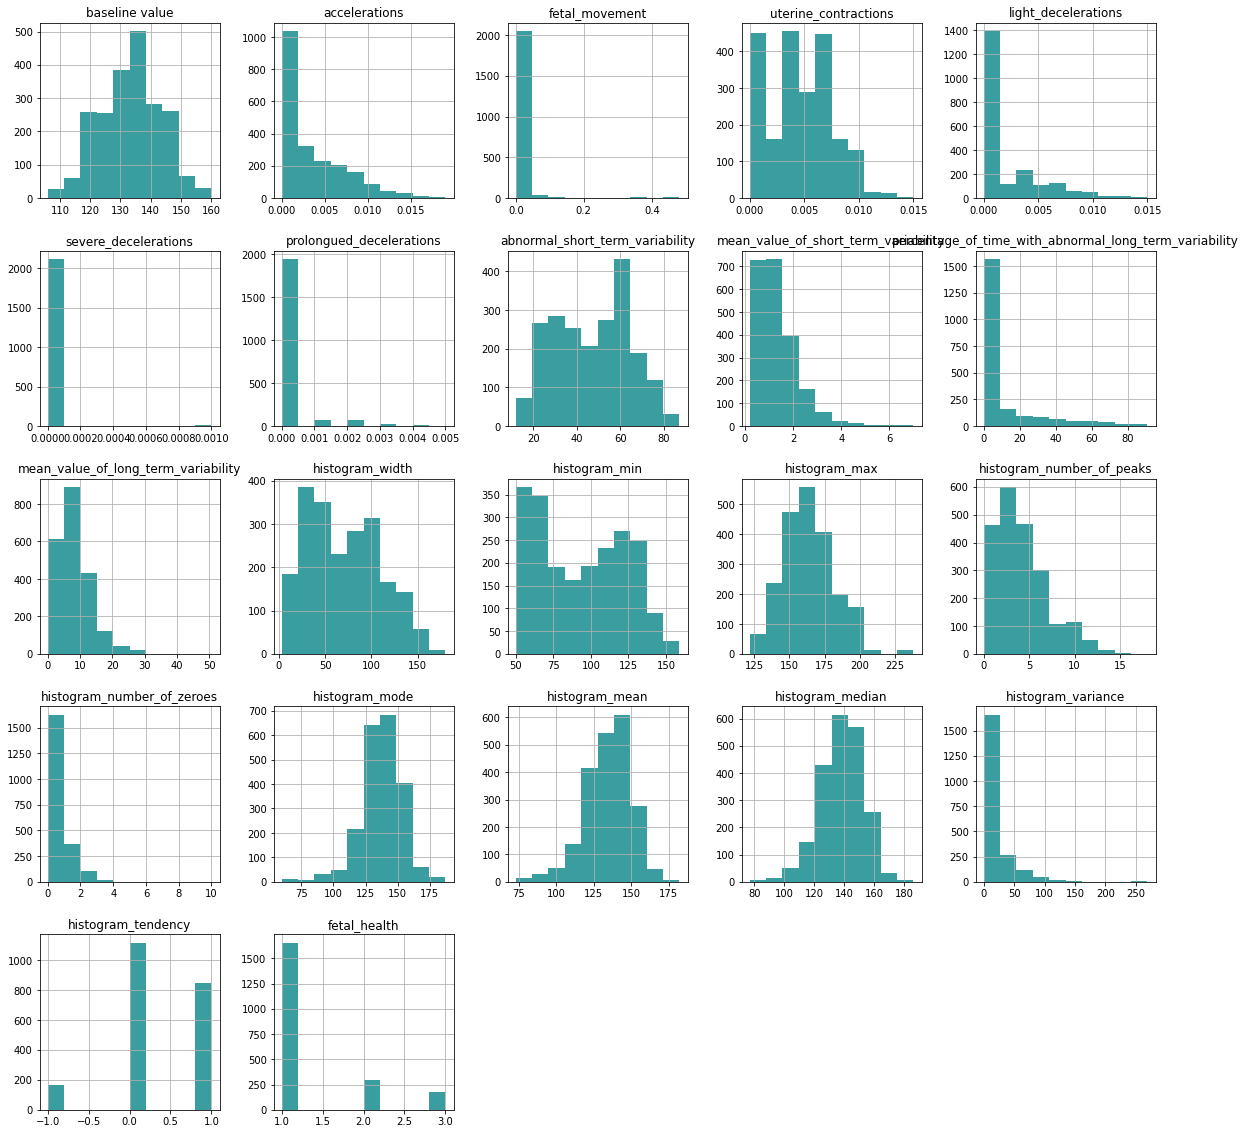

In [4]:
dataset.hist(figsize = (20,20), color = "#3A9DA0");

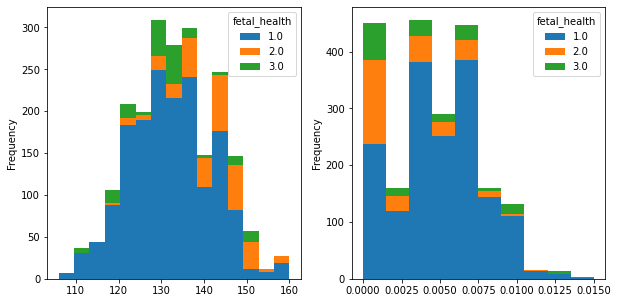

In [5]:
plt.figure(figsize=(10,5))

dataset.pivot(columns="fetal_health")["baseline value"].plot.hist(bins=15,stacked=True,ax=plt.subplot(1,2 , 1));
dataset.pivot(columns="fetal_health")["uterine_contractions"].plot.hist(stacked=True,ax=plt.subplot(1, 2, 2));


In questi grafici si può già notare la correlazione tra i battiti cardiaci e le contrazioni uterine con la salute del feto.

### Analisi della variabile da predire

La variabile da predire è ***fetal_health*** che rappresenta la salute del feto e contiene valori:
* 1 - Normale
* 2 - Sospetto 
* 3 - Patologico \\
Nella cella seguente possiamo notare come nel 77% dei casi il feto risulta completamente in salute, nel 13% presenta delle anomalie sospette mentre solo nel 0.08% presenta delle patologie.

In [6]:
dataset["fetal_health"].value_counts(normalize=True)

1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: fetal_health, dtype: float64

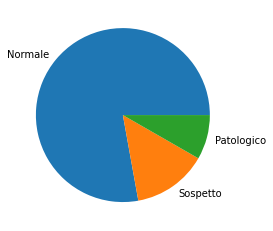

In [7]:
plt.pie(dataset["fetal_health"].value_counts(normalize=True),labels=["Normale", "Sospetto","Patologico"]);

Le 3 classi individuate risultano abbastanza sbilanciate e sarà quindi necessario considerare questo aspetto quando andremo a valutare i nostri modelli di classificazione.
Ad esempio se classificassimo tutte le istanze come 1 (Normale) avremmo comunque un'accuratezza del 78%.
Andremo ad utilizzare quindi altre tecniche di valutazione come F1 Score.

### Analisi della correlazione delle features

Nel grafico seguente andremo ad analizzare quali sono le variabili che hanno una correlazione maggiore con la variabile da predire *fetal_health*. \\
Dalla matrice di correlazione possiamo notare che le variabili più scure come ad esempio **prolongued_decelerations**,**abnormal_short_term_variability** e **percentage_of_time_with_abnormal_long_term_variability** risultano essere quelle con una correllazione maggiore.

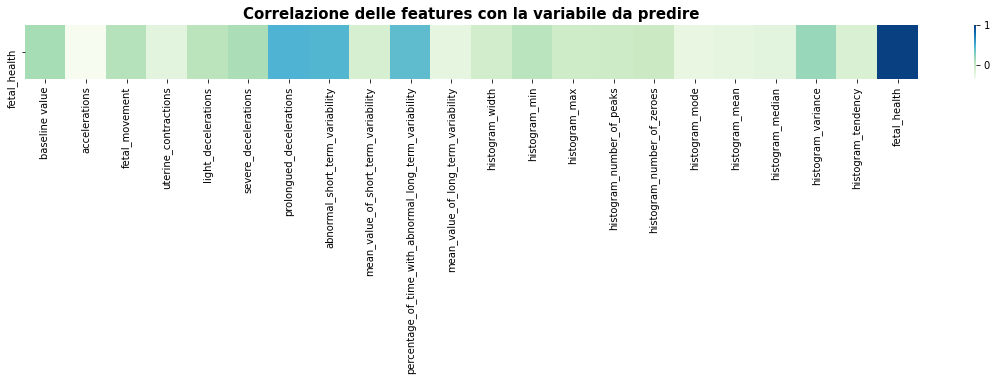

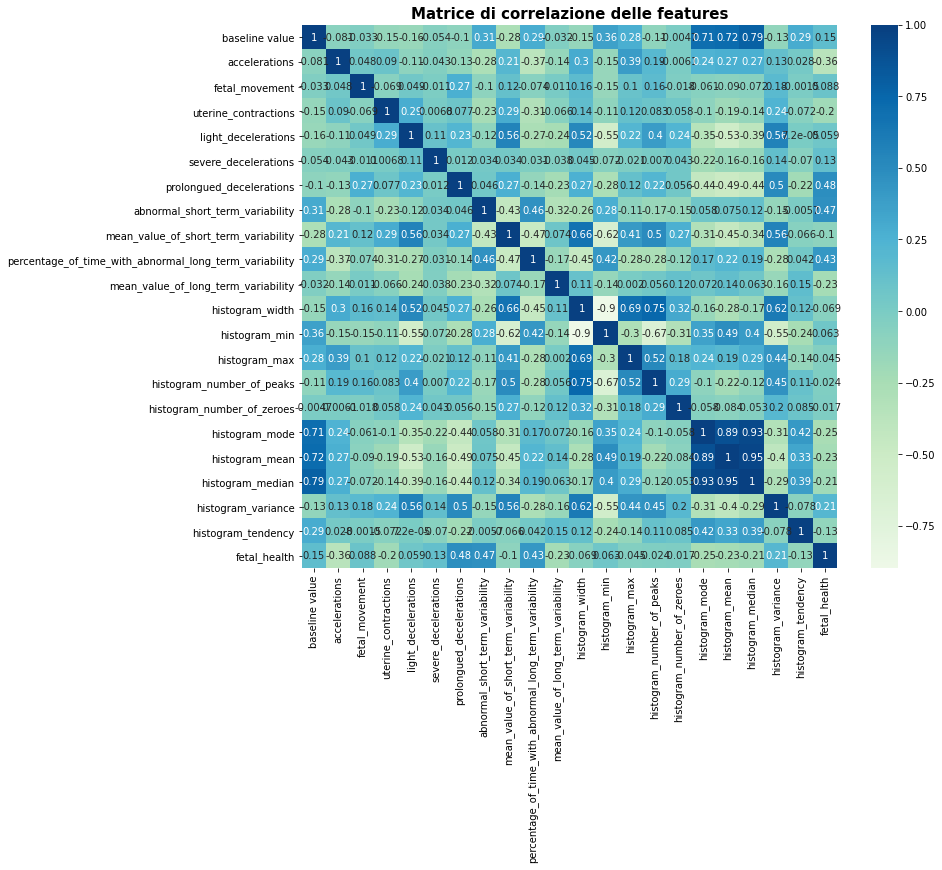

In [8]:
correlation_matrix = dataset.select_dtypes(exclude="object").corr()
f,ax=plt.subplots(figsize=(20,1))
sns.heatmap(correlation_matrix.sort_values(by=["fetal_health"], ascending=False).head(1), cmap="GnBu")
plt.title("Correlazione delle features con la variabile da predire", weight="bold", fontsize=15)
plt.show()

plt.figure(figsize=(12,10))  
plt.title("Matrice di correlazione delle features",weight="bold", fontsize=15)
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(correlation_matrix,annot=True, cmap="GnBu", center=0);

Nel grafico seguente invece si può notare la correlazione tra le decelerazioni prolungate del battito e la salute del feto.
Il valore delle decelerazioni aumenta in modo proporzionale al numero di istanze con patologie.

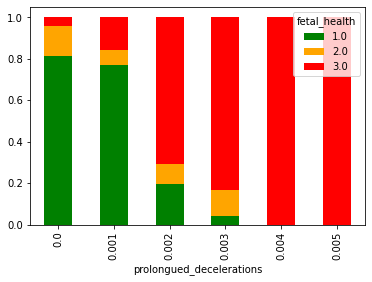

In [9]:
decelerations = dataset.groupby(["prolongued_decelerations", "fetal_health"])["fetal_health"].count().unstack()
fetal_health_and_decelerations = decelerations.T.div(decelerations.T.sum()).T
fig, ax = plt.subplots()

fetal_health_and_decelerations.plot(kind="bar", stacked=True, color=["green", "orange","red"], ax=ax);


La correlazione tra le contrazioni uterine e la salute del feto si può esprimere nel seguente modo:
- Valori 1 (Normali) --> contrazioni medie = 0.05
- Valori 2 (Sospetto) --> contrazioni medie = 0.01
- Valori 3 (Patologia) --> contrazioni medie = 0.03

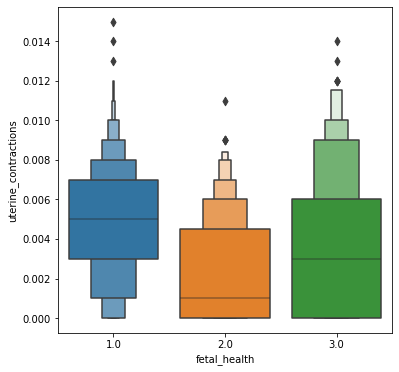

In [10]:
figure = plt.figure(figsize=(6,6))
sns.boxenplot(x='fetal_health', y='uterine_contractions', data=dataset);

## **Preprocessing dei dati**

### Ricerca di valori Null e mancanti

In [11]:
valori_null = dataset.columns[dataset.isnull().any()]
print('Valori Null = ', valori_null.size)

valori_mancanti = dataset.columns[dataset.isna().any()]
print('Valori mancanti = ', valori_mancanti.size)

Valori Null =  0
Valori mancanti =  0


### Ricerca di valori duplicati

In [12]:
dataset.drop_duplicates(inplace=True)
dataset.shape

(2113, 22)

### Distribuzione dei valori delle variabili

Il grafico seguente mostra il range di valori che assumono le nostre features.
Si può notare che le variabili hanno intervalli diversi e sarà quindi necessario applicare delle tecniche di standardizzazione dei dati per migliorare l'accuratezza dei modelli.

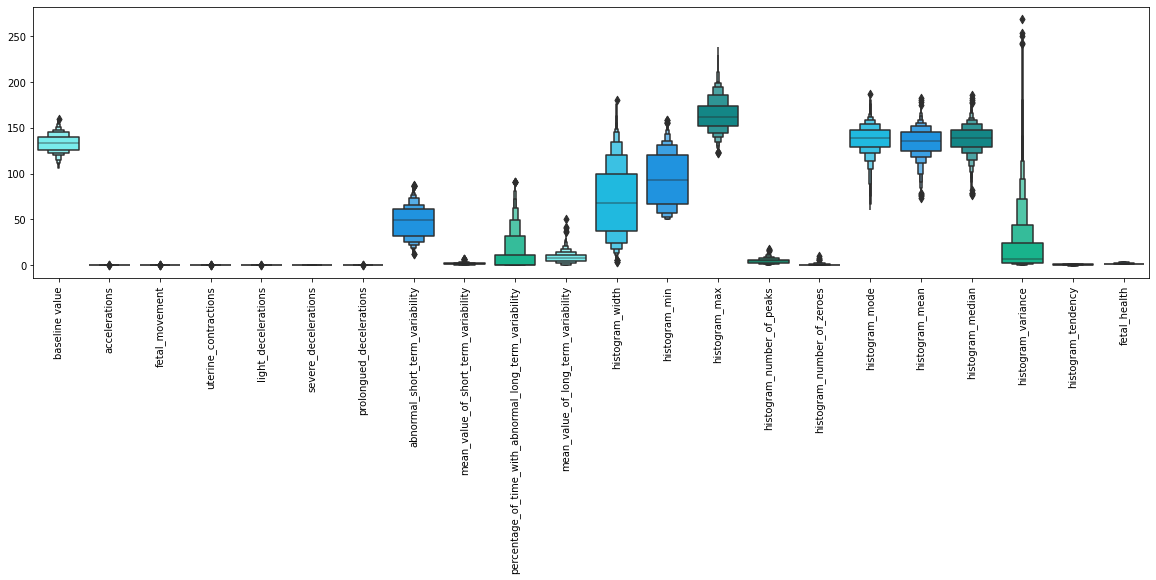

In [13]:
def plot_features_range(dataset):
  colors =["#66ffff","#00ccff","#0099ff","#009999", "#00cc99"]
  plt.figure(figsize=(20,5))
  sns.boxenplot(data = dataset,palette = colors)
  plt.xticks(rotation=90)
  plt.show()
plot_features_range(dataset)

### Standardizzazione dei dati

Utilizziamo il filtro StandardScaler per standardizzare i nostri dati e ripetiamo il grafico precedente per vedere i risultati ottenuti.

Dal grafico possiamo notare che , una volta applicata la standardizzazione , le variabili assumono tutte valori in un intervallo vicino.

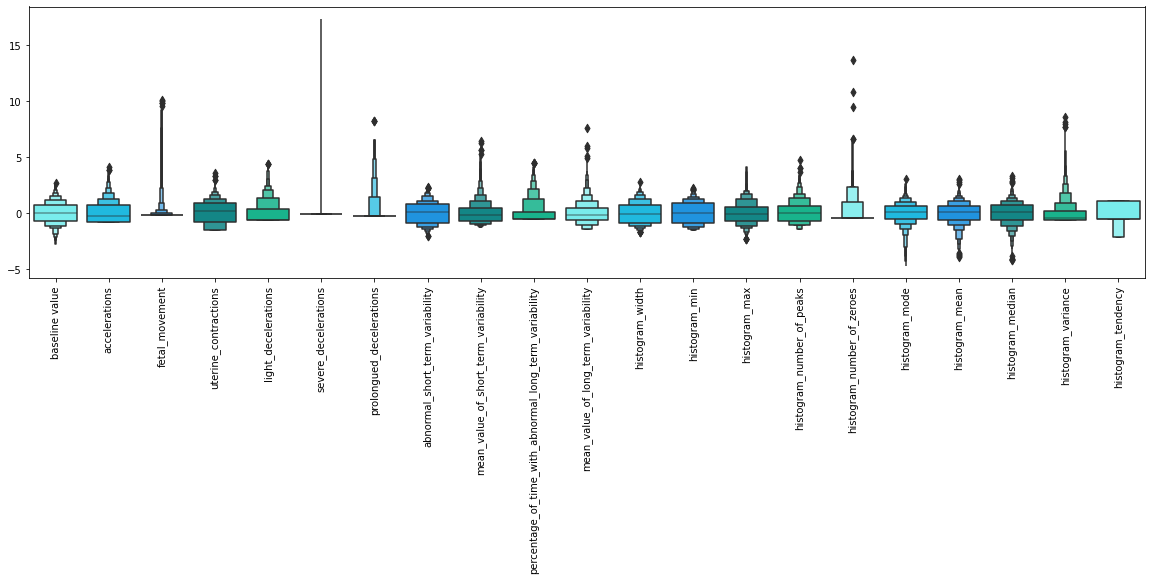

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X=dataset.drop(["fetal_health"],axis=1)
y=dataset["fetal_health"]

features = list(X.columns)
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=features)   

plot_features_range(X_std)

### Splitting dei dati in Training e Validation Sets

Prima di addestrare i nostri modelli andiamo a dividere il dataset in Training e Validation Set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 42)

print("Training Set: "+ str(X_train.shape) + "\n"+ "Validation Set: " + str(X_test.shape))

Training Set: (1479, 21)
Validation Set: (634, 21)


### Bilanciamento delle classi

Proviamo ora ad utilizzare delle tecniche di bilanciamento delle classi come SMOTE e creiamo un nuovo training set bilanciato.

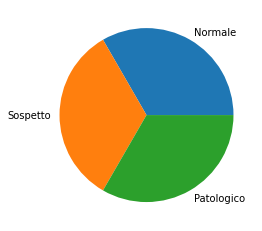

In [16]:
from imblearn.over_sampling import SMOTE 

smot = SMOTE()
smot_x_train, smot_y_train = smot.fit_resample(X_train, y_train)
plt.pie(pd.Series(smot_y_train).value_counts(),labels=["Normale", "Sospetto","Patologico"]);

## **Modelli di classificazione**

Creiamo la funzione *grid_search_with_cross_validation()* che andremo ad utilizzare nei vari modelli in modo da evitare ripetizioni di codice.

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

models = {}
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

def grid_search_with_cross_validation(model, parameters, kf, X_train,y_train,X_val,y_val, scoring=None):
    grid_search = GridSearchCV(model, parameters, scoring=scoring, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    score = grid_search.score(X_test, y_test)
    print("                Score: {}".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    return grid_search.best_estimator_, score


### Perceptron

Inizialmente andremo ad addestrare il modello di classificazione *Perceptron* senza specificare nessun parametro per vedere come si comporta sul dataset.

In [18]:
perceptron_model = Perceptron(random_state=42)
perceptron_model.fit(X_train,y_train)
perceptron_model.score(X_test,y_test)

0.47318611987381703

Senza standardizzazione dei dati il modello ha un'accuratezza molto bassa.

Andiamo ora ad aggiungere al nostro classificatore una serie di iperparametri che verranno testati tramite GridSearch

In [19]:
perceptron = Pipeline([
    ("scaler",StandardScaler()),
    ("per",Perceptron(random_state=42))

])

parameters = {
    "scaler":[None,StandardScaler()],
    "per__penalty": ["l2", "l1", "elasticnet",None],
    "per__alpha": np.logspace(-3, 3, 7),
    "per__fit_intercept": [False, True]
}

per_model, score = grid_search_with_cross_validation(perceptron, parameters, k_fold, X_train,y_train,X_test,y_test)

models["Perceptron"] = {"Model": per_model, "Score": score}

print("\t\tCon training set bilanciato:\n")
per_model_balanced,score = grid_search_with_cross_validation(perceptron, parameters, k_fold, smot_x_train,smot_y_train,X_test,y_test)




                Score: 0.8501577287066246
                Best params: {'per__alpha': 0.001, 'per__fit_intercept': True, 'per__penalty': None, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

		Con training set bilanciato:

                Score: 0.8438485804416404
                Best params: {'per__alpha': 0.001, 'per__fit_intercept': True, 'per__penalty': None, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Possiamo notare che la combinazione che ci permette di raggiungere lo score maggiore è:

*   Standardizzazione dei dati
*   Nessuna regolarizzazione
*   Nessun bilanciamento delle classi
*   Aggiunta dell'intercetta




### Logistic Regression

Proviamo a migliorare l'accuratezza utilizzando un modello di regressione logistica.

La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare.

I parametri che andremo a impostare rappresentano:
- standardizzazione dei dati
- utilizzo di modelli multiclasse
- regolarizzazione dei dati
- paremetro C : è il reciproco del peso della regolarizzazione e influenza la penalità data alle classificazioni errate



In [20]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver='saga',random_state=42,fit_intercept=True))
])


parameters={
    "scaler": [None,StandardScaler()],
    "lr__multi_class": [None,"ovr","multinomial"],
    "lr__penalty": ["l2","l1"],
    "lr__C": [0.01,0.1,1,10]
}


log_model, score = grid_search_with_cross_validation(log_reg, parameters, k_fold,X_train,y_train,X_test,y_test)
models["Logistic Regression"] = {"Model" : log_model, "Score": score}

                Score: 0.9132492113564669
                Best params: {'lr__C': 1, 'lr__multi_class': 'multinomial', 'lr__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Notiamo che la combinazione migliore nella regressione logistica si ottiene con:
- modello multiclasse `multinomial`
- regolarizzazione L1
- standardizzazione dei dati
- C = 1 (regolarizzazione di default)

### Support Vector Machines

Il metodo delle Support Vector Machines (SVM) è stato formulato in origine per la classificazione binaria
Consiste nell'individuare un iperpiano di separazione ottimale tra le due classi basandosi sulle istanze più vicine ad esso, i cosiddetti _support vector_ .

Come nella regressione kernel ridge vista in precedenza, possono essere utilizzate delle funzioni kernel per effettuare una classificazione non lineare

- Il parametro *gamma* rappresenta un coefficiente moltiplicativo per il kernel
- il parametro *kernel* serve a specificare la funzione kernel da utilizzare come ad esempio poly (polinomiale) oppure rbf (radial-basis-function)

In [21]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

parameters = {
    "scaler": [StandardScaler()],
    'svc__gamma' : [0.1, 1, 5],
    'svc__C' : [1, 5],
    'svc__kernel' : ['rbf', 'poly']
}

svm_model, score= grid_search_with_cross_validation(svm, parameters, k_fold,X_train,y_train,X_test,y_test )
models["Support Vector Machine"] = {"Model": svm_model, "Score": score}


                Score: 0.9416403785488959
                Best params: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc__C': 5, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}



La combinazione migliore si ottiene con:
- standardizzazione dei dati
- coefficiente gamma = 0.1
- parametro C = 5
- funzione kernel `rbf`

### Decision Tree Classifier

Proviamo ora ad utilizzare dei modelli di classificazione basati su alberi decisionali.
Un modello ad albero decisionale è rappresentato da un oggetto `DecisionTreeClassifier`. \\
Gli iperparametri del modello consentono di regolare la complessità dell'albero risultante.
- il parametro `max_depth` indica la profondità massima dell'albero \\
 l'impostazione di una profondità massima può essere importante sia per limitare la complessità dell'albero che per evitare l'overfitting.
- `min_samples_split` : numero minimo di casi di training (`samples`) contenuti in un nodo intermedio: nodi con un numero inferiore di casi non possono essere ulteriormente suddivisi.
- `min_samples_leaf`: numero minimo di casi di trainfing contenuti nelle foglie
- `max_features`: numero massimo di features da considerare

In [22]:
decision_tree = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])


parameters = {"scaler": [StandardScaler()],
             'tree__min_samples_split': range(2, 4, 1),
             'tree__min_samples_leaf': range(1, 4, 1), 
             'tree__max_depth': [None] + [i for i in range(2, 10)],
             'tree__max_features': range(2, X_train.columns.size, 1)}

decision_tree_model, score = grid_search_with_cross_validation(decision_tree, parameters, k_fold, X_train,y_train,X_test,y_test)
models["Decision Tree"] = {"Model": decision_tree_model, "Score" : score}

                Score: 0.9369085173501577
                Best params: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'tree__max_depth': 9, 'tree__max_features': 17, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 3}



Possiamo notare che riusciamo a raggiungere un'accuratezza abbastanza alta con le seguenti combinazioni:

- nessuna standardizzazione dei dati
- `max_depth` = 9
- `min_samples_split` = 3
- `min_samples_leaf` = 1
- `max_features` = 17

Abbassando quindi il numero massimo di features da 21 a 17  e con una profondità di 9 livelli il modello riesce a raggiungere il risultato migliore.

### Random Forest

E' un metodo di ensemble learning, che fa uso di un insieme di alberi decisionali che indipendentemente svolgono il loro algoritmo di classificazione, il risultato finale viene poi democraticamente scelto fra le varie predizioni ottenute dagli estimatori. \\
Questa tecnica generalmente tende a diminuire il tipico overfitting dei singoli alberi decisionali.

In [23]:
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

parameters = {"scaler": [StandardScaler()],
             'forest__n_estimators': range(5, 10),
             'forest__min_samples_split': range(2, 5), 
             'forest__max_depth': [None] + [i for i in range(1, 5)],
             'forest__max_features': [int(math.sqrt(X_train.columns.size)), X_train.columns.size -1]  }

forest_model_nb, score = grid_search_with_cross_validation(forest_model, parameters, k_fold, X_train,y_train,X_test,y_test)
models["Random Forest"] = {"Model": forest_model_nb, "Score" : score}

                Score: 0.9526813880126183
                Best params: {'forest__max_depth': None, 'forest__max_features': 4, 'forest__min_samples_split': 2, 'forest__n_estimators': 7, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Proviamo ora ad addestrare il modello Random Forest utilizzando il training set bilanciato:

In [24]:
balanced_random_forest,score = grid_search_with_cross_validation(forest_model, parameters, k_fold, smot_x_train,smot_y_train,X_test,y_test)

                Score: 0.9400630914826499
                Best params: {'forest__max_depth': None, 'forest__max_features': 4, 'forest__min_samples_split': 2, 'forest__n_estimators': 9, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Notiamo che utilizzando gli stessi parametri con un training set con classi bilanciate l'accuratezza del modello non aumenta.

Visualizziamo infine le features più rilevanti per il modello:

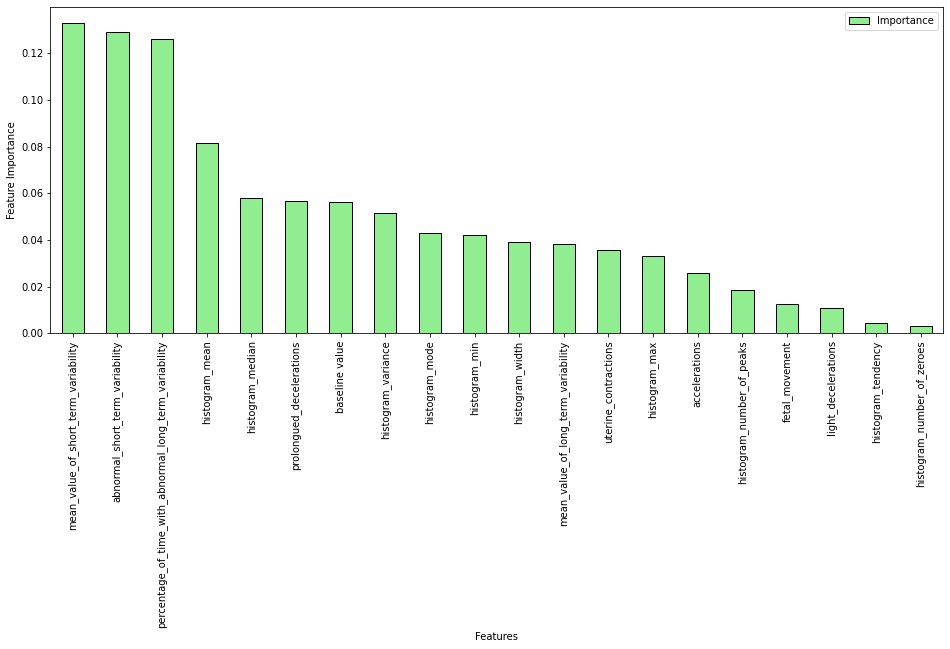

In [58]:
feature_importance=pd.DataFrame(models["Random Forest"]["Model"]['forest'].feature_importances_,index=X_train.columns, columns=['Importance']).sort_values(by='Importance',ascending=False).head(20)
ax=feature_importance.plot(kind='bar', figsize=(16,6),color='lightgreen',edgecolor="black");
ax.set(ylabel='Feature Importance');
ax.set(xlabel='Features');

## Valutazione dei modelli

### Riepilogo accuratezza ottenuta

Andiamo a confrontare la percentuale di accuratezza ottenuta nei vari modelli

In [63]:
accuracy = []
for model in models.items():
  accuracy.append(model[1]["Score"])
models_score = pd.DataFrame({"Accuratezza":accuracy},index=models.keys()) 
models_score

,Accuratezza
Perceptron,0.850158
Logistic Regression,0.913249
Support Vector Machine,0.941640
Decision Tree,0.936909
Random Forest,0.952681


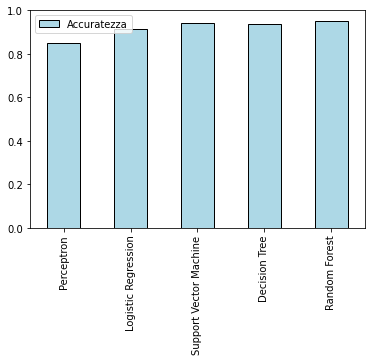

In [65]:
models_score.plot.bar(facecolor='lightblue',edgecolor='black');

### Confusion Matrix

Come anticipato in precedenza le nostre classi sono abbastanza sbilanciate per cui l'accuratezza può non essere un valore affidabile. \\
Nella matrice di confusione ogni colonna della matrice rappresenta i valori predetti, mentre ogni riga rappresenta i valori reali. \\
Lungo la diagonale abbiamo quindi le quantità di classificazioni corrette, al di fuori abbiamo invece le quantità di errori. 

Creiamo una funzione per calcolare la matrice di confusione e la testiamo su ogni modello di classificazione.

In [66]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


def get_confusion_matrix(model_name,X_test,y_test):
  model = models[model_name]
  y_pred = model["Model"].predict(X_test)
  return confusion_matrix(y_test,y_pred)


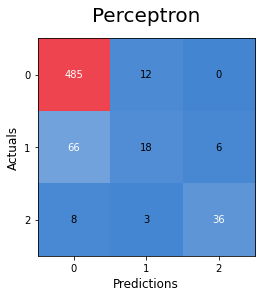

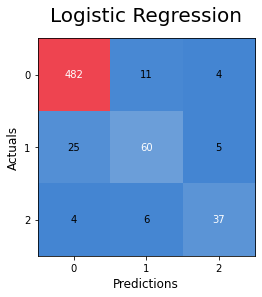

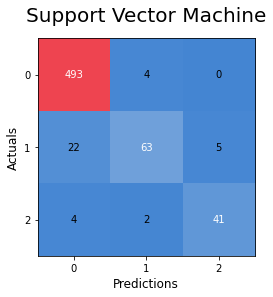

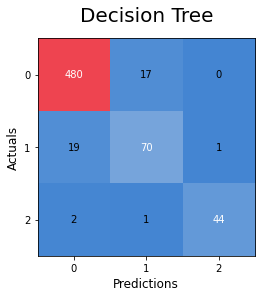

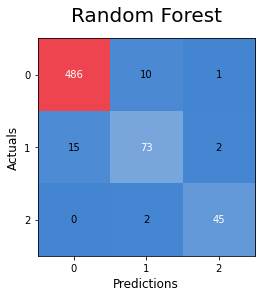

In [67]:
for i in models.keys():
  cm = get_confusion_matrix(i,X_test,y_test)
  fig = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4), cmap=cmap)
  plt.xlabel('Predictions', fontsize=12);
  plt.ylabel('Actuals', fontsize=12)
  plt.title(i, fontsize=20)
  plt.show()

Le varie matrici di confusione sono in linea con la classifica dei modelli eseguita con la percentuale di accuratezza.

### F1-Score

Andiamo a calcolare ora l' **F1-Score** dei modelli ossia la media armonica tra **precision** e **recall**

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_precision(model_name,X_test,y_test):
  model = models[model_name]
  y_pred = model["Model"].predict(X_test)
  return precision_score(y_test,y_pred,average="macro")

def get_recall(model_name,X_test,y_test):
  model = models[model_name]
  y_pred = model["Model"].predict(X_test)
  return recall_score(y_test,y_pred,average="macro")

def get_f1_score(model_name,X_test,y_test):
  model = models[model_name]
  y_pred = model["Model"].predict(X_test)
  return f1_score(y_test,y_pred,average="macro")

In [69]:
models_precision = []
models_recall = []
models_f1 = []
for model in models.keys():
  models_precision.append(get_precision(model,X_test,y_test))
  models_recall.append(get_recall(model,X_test,y_test))
  models_f1.append(get_f1_score(model,X_test,y_test))

models_score["Precision"] = models_precision
models_score["Recall"] = models_recall
models_score["F1-Score"] = models_f1

models_score

,Accuratezza,Precision,Recall,F1-Score
Perceptron,0.850158,0.756739,0.647271,0.673411
Logistic Regression,0.913249,0.842272,0.807907,0.823537
Support Vector Machine,0.941640,0.918084,0.854764,0.881549
Decision Tree,0.936909,0.910439,0.893248,0.901654
Random Forest,0.952681,0.922128,0.915475,0.918534


Dalla tabella possiamo notare come il Perceptron risulta essere il modello peggiore mentre Random Forest ha ottenuto ancora lo score più alto.

### Learning Curve

La curva di apprendimento è un grafico che mostra i cambiamenti nelle prestazioni di apprendimento di un modello nel tempo in termini di esperienza.
Fornisce quindi una rappresentazione visiva del tempo necessario per acquisire competenze e addestrarsi su un dataset.

Tramite questi grafici è possibile analizzare se il modello è soggetto ad overfit, underfit oppure se il traning o validation sets utilizzati non sono rappresentativi del dominio del problema.


In [70]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#80CBC4",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#00897B",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

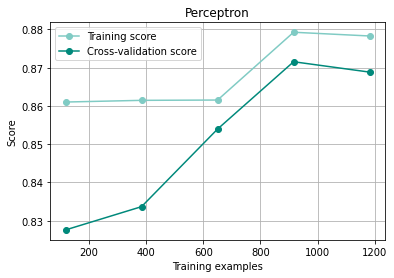

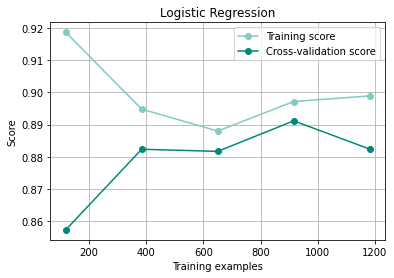

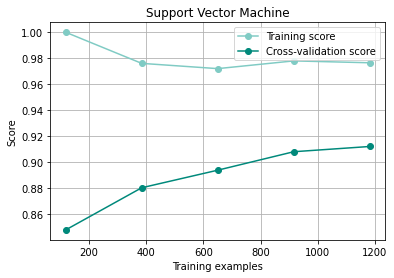

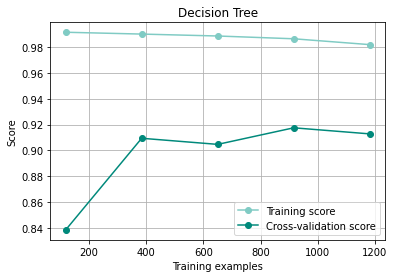

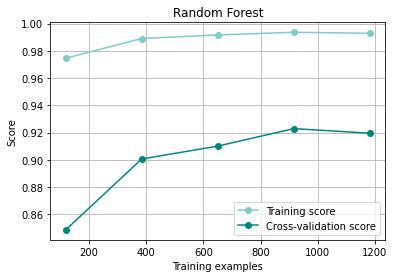

In [71]:
for model in models.keys():
  plot_learning_curve(models[model]["Model"],model,X_train,y_train);
